# WHATSAPP GROUP CHAT ANALYSIS

The goal of this project is to analyse data from a whatsapp group. I will be looking at the frequency of messages sent, active and inactive members as well as the most active and least active members of the group. I'll also do some plots to visualization of the results.

The first step is to export the data from Whatsapp by following the steps below:

- Open the chat.
- Access More options > More > Export chat.
- Choose either "Without media" or "Include media".

Your chat history will be attached as a .txt document in an email.
Note:

Opting for "Include media" adds the most recent media as attachments.
With media, you can export up to the 10,000 latest messages; without media, up to 40,000 messages. These limits are set by maximum email sizes.

Once done with the export, you will receive the .txt file in your email.

## Importing libraries

Next, we need to import the required libraries for the project

- Regex (re) is for extracting and manipulating strings based on specific patterns.

- Wordcloud is for generating wordclouds from the text messages.

- `warnings.filterwarnings('ignore')` is used to hide warning messages that could otherwise appear during code execution, keeping the notebook output clean and focused on the main results.

- `Counter` is a specialized dictionary subclass designed for counting hashable objects. With `Counter` you can quickly count the occurrences of elements in an iterable or mapping.

In [62]:
import datetime
import seaborn as sns
import pandas as pd
import re
import emoji
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

This function converts the raw txt file to a dataframe.

In [63]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    return df

# Reading the file

In [64]:
df = rawToDf('D:\Downloads\WhatsApp Chat with 📚📖 BOOKCLUB.txt', '24hr')
df

,date_time,user,message
0,2023-04-25 16:22:00,group_notification,Messages and calls are end-to-end encrypted. N...
1,2022-09-14 21:19:00,group_notification,"Group creator created group ""📚📖 BOOKCLUB"""
2,2023-04-25 16:22:00,group_notification,You joined using this group's invite link
3,2023-04-25 19:59:00,+254 790 122006,"Hello guys, we are live"
4,2023-04-25 20:01:00,+254 724 892675,Am waiting for the entry
...,...,...,...
874,2024-02-26 09:13:00,+254 710 678723,Yes
875,2024-02-26 17:41:00,+254 790 122006,If you can't succeed as an employee at a corpo...
876,2024-02-29 10:44:00,+254 790 122006,Good morning people. I work for a large corp...
877,2024-02-29 11:08:00,+254 741 558633,Where is the middle ground


### Note:

To handle WhatsApp texts effectively, a straightforward line-by-line method won't work due to the way messages span multiple lines. Using regular expressions helps in determining whether a line represents a new message or is part of an existing one.

Here's how it goes: Each line is split by commas, focusing on the first part. If the line starts with a valid date, it's recognized as the start of a new message and added to the message list. Otherwise, it's considered part of the previous message and added to it for continuity.

In [65]:
df['user'].unique()

array(['group_notification', '+254 790 122006', '+254 724 892675',
       '+254 726 022534', '+254 746 661477', '+254 741 558633',
       '+254 708 940636', '+254 704 705599', '+254 710 678723',
       '+254 758 830577', '+254 724 017355', '+254 708 890447',
       '+254 711 723978', '+254 792 847320', '+254 702 713245',
       '+254 721 384737', '+254 700 425943', '+254 743 925416',
       '+254 713 404079', '+254 708 371636', '+254 715 797836',
       '+254 769 560316', '+254 704 743901', '+254 790 801667',
       '+254 710 415768', '+254 728 918366', '+254 725 170121',
       '+254 703 229377', '+254 721 510633', '+254 704 698031',
       '+254 727 797779', 'Qminds Book Club', '+254 794 800601',
       '+254 718 228639', '+254 791 966644'], dtype=object)

## Splitting the datetime column to year, month, day and date

In [66]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())
df

,date_time,user,message,day,month,year,date
0,2023-04-25 16:22:00,group_notification,Messages and calls are end-to-end encrypted. N...,Tue,Apr,2023,2023-04-25
1,2022-09-14 21:19:00,group_notification,"Group creator created group ""📚📖 BOOKCLUB""",Wed,Sep,2022,2022-09-14
2,2023-04-25 16:22:00,group_notification,You joined using this group's invite link,Tue,Apr,2023,2023-04-25
3,2023-04-25 19:59:00,+254 790 122006,"Hello guys, we are live",Tue,Apr,2023,2023-04-25
4,2023-04-25 20:01:00,+254 724 892675,Am waiting for the entry,Tue,Apr,2023,2023-04-25
...,...,...,...,...,...,...,...
874,2024-02-26 09:13:00,+254 710 678723,Yes,Mon,Feb,2024,2024-02-26
875,2024-02-26 17:41:00,+254 790 122006,If you can't succeed as an employee at a corpo...,Mon,Feb,2024,2024-02-26
876,2024-02-29 10:44:00,+254 790 122006,Good morning people. I work for a large corp...,Thu,Feb,2024,2024-02-29
877,2024-02-29 11:08:00,+254 741 558633,Where is the middle ground,Thu,Feb,2024,2024-02-29


## Check overall frequency of total messages on the group.

Here we will use the date and the count of messages to understand the overall trend of messaging in the group.

In [67]:
new_df = df.copy()

In [68]:
new_df['message_count'] = new_df.shape[0]*[1]      # adding extra helper column --> message_count.
new_df

,date_time,user,message,day,month,year,date,message_count
0,2023-04-25 16:22:00,group_notification,Messages and calls are end-to-end encrypted. N...,Tue,Apr,2023,2023-04-25,1
1,2022-09-14 21:19:00,group_notification,"Group creator created group ""📚📖 BOOKCLUB""",Wed,Sep,2022,2022-09-14,1
2,2023-04-25 16:22:00,group_notification,You joined using this group's invite link,Tue,Apr,2023,2023-04-25,1
3,2023-04-25 19:59:00,+254 790 122006,"Hello guys, we are live",Tue,Apr,2023,2023-04-25,1
4,2023-04-25 20:01:00,+254 724 892675,Am waiting for the entry,Tue,Apr,2023,2023-04-25,1
...,...,...,...,...,...,...,...,...
874,2024-02-26 09:13:00,+254 710 678723,Yes,Mon,Feb,2024,2024-02-26,1
875,2024-02-26 17:41:00,+254 790 122006,If you can't succeed as an employee at a corpo...,Mon,Feb,2024,2024-02-26,1
876,2024-02-29 10:44:00,+254 790 122006,Good morning people. I work for a large corp...,Thu,Feb,2024,2024-02-29,1
877,2024-02-29 11:08:00,+254 741 558633,Where is the middle ground,Thu,Feb,2024,2024-02-29,1


In [69]:
new_df = new_df.groupby('date').sum('message_count').reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
new_df

,date,year,message_count
0,2022-09-14,2022,1
1,2023-04-25,24276,12
2,2023-04-26,26299,13
3,2023-04-27,101150,50
4,2023-04-28,10115,5
...,...,...,...
92,2024-02-21,6072,3
93,2024-02-22,12144,6
94,2024-02-23,14168,7
95,2024-02-26,24288,12


In [70]:
new_df.drop(columns='year', inplace=True)         # let's drop the year since we will need only the date and message count for our analysis
new_df

,date,message_count
0,2022-09-14,1
1,2023-04-25,12
2,2023-04-26,13
3,2023-04-27,50
4,2023-04-28,5
...,...,...
92,2024-02-21,3
93,2024-02-22,6
94,2024-02-23,7
95,2024-02-26,12


## Plotting the first graph for messages sent per day

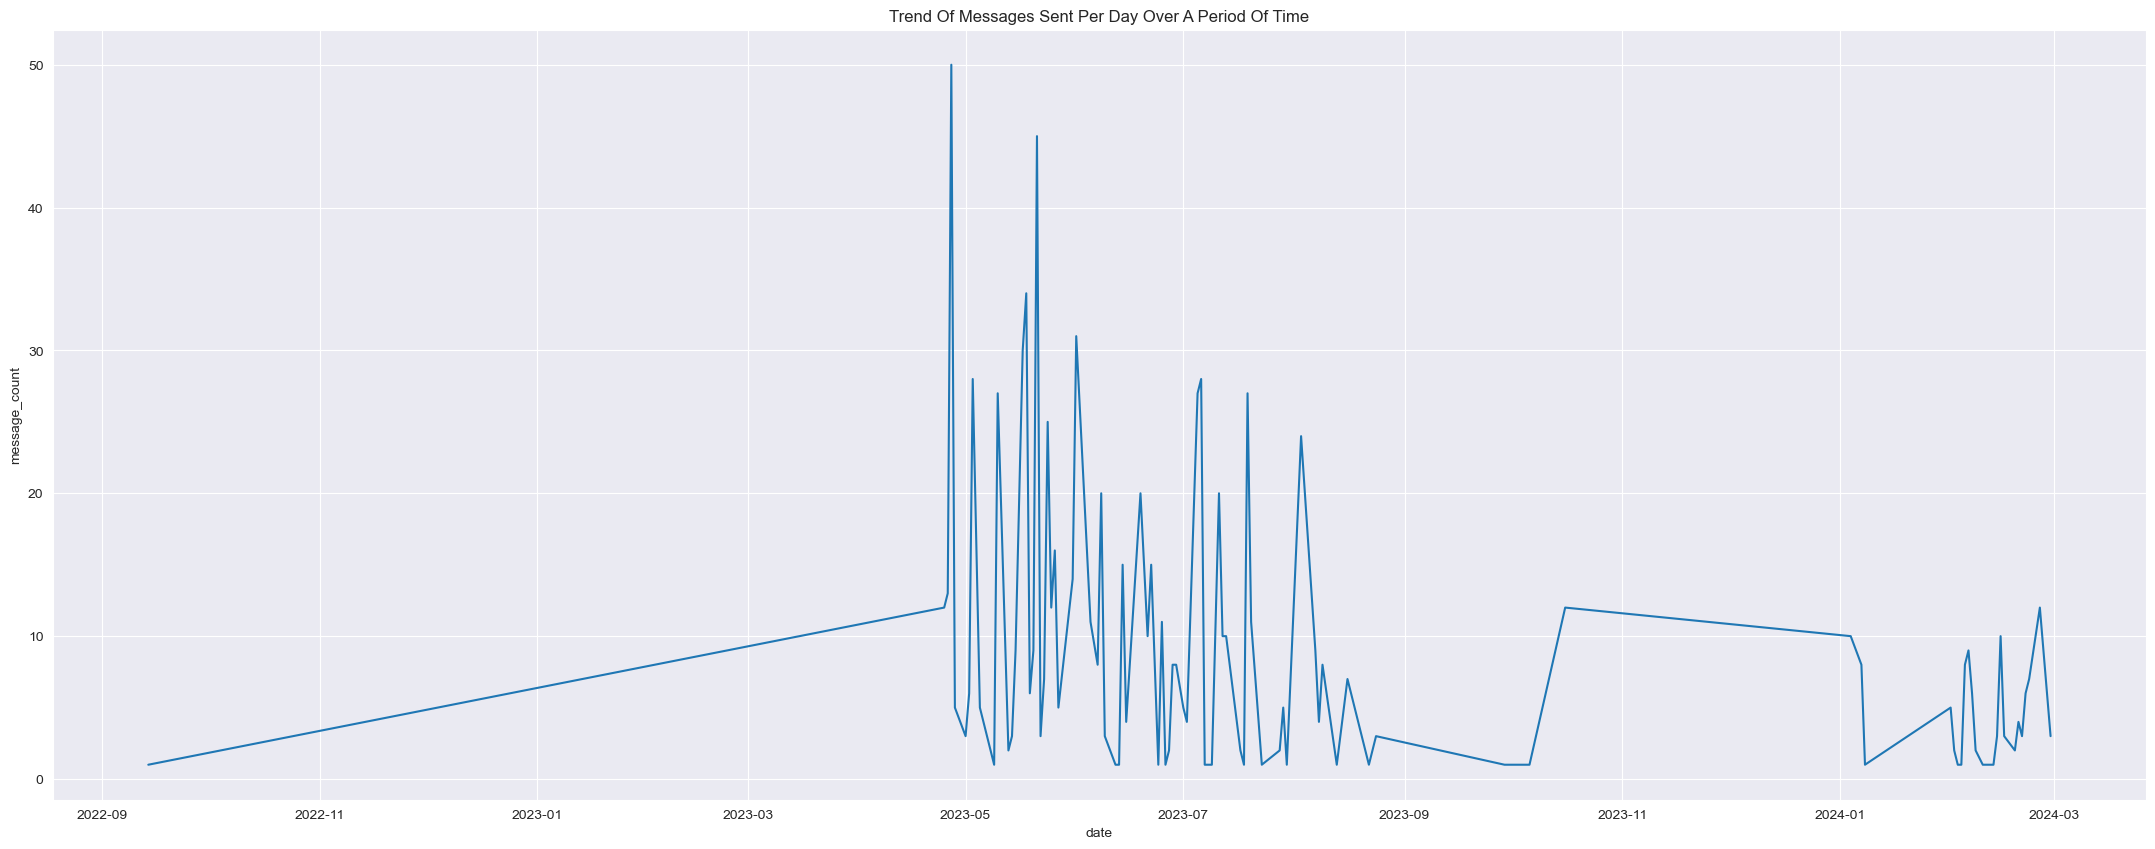

In [71]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
plt.figure(figsize = (27, 10))     # Same as ``


plt.title('Trend Of Messages Sent Per Day Over A Period Of Time');
sns.lineplot(x=new_df.date, y=new_df.message_count);   

 #Alternatively
#plt.plot(new_df.date, new_df.message_count)


# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

The group was created some time in 2022 and we can see the number of messages having a steep incline over the next few months until May of 2023 when the highest number of messages was recorded. Since then the number of messages per day has fluctuated but not close to the level of May.

In [72]:
## Sorting the message count in descending order in order to get the top ten most active days of messaging

top_10 = new_df.sort_values(by="message_count", ascending=False).head(10)
top_10.reset_index(inplace=True)
top_10.drop(columns='index', inplace = True)
top_10

,date,message_count
0,2023-04-27,50
1,2023-05-21,45
2,2023-05-18,34
3,2023-06-01,31
4,2023-05-17,30
5,2023-07-06,28
6,2023-05-03,28
7,2023-05-10,27
8,2023-07-19,27
9,2023-07-05,27


## Plotting the most active days of messaging

<Axes: title={'center': 'Top 10 most active days of messaging'}, xlabel='date', ylabel='message_count'>

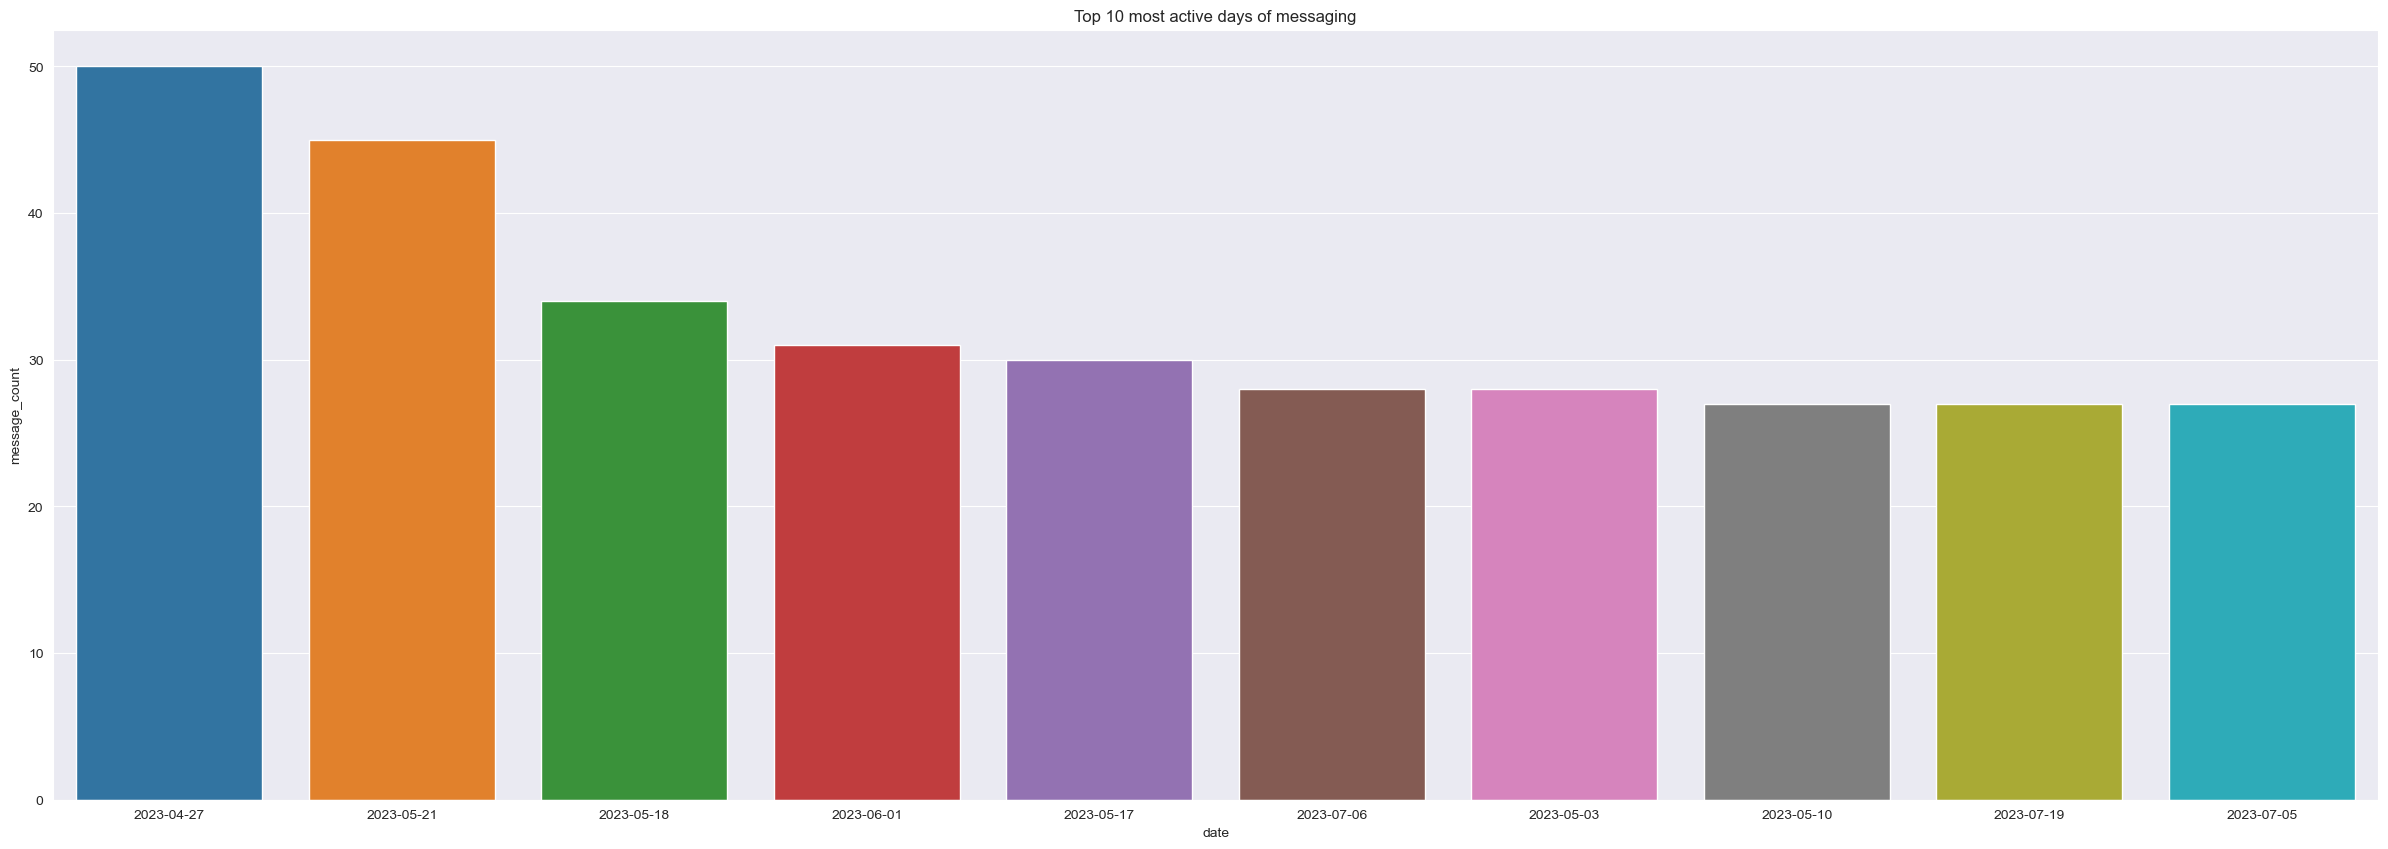

In [73]:
plt.figure(figsize = (30, 10))     

plt.title('Top 10 most active days of messaging');
sns.barplot(x=top_10.date, y=top_10.message_count)  

27/04/2023 was the day with the most number of messages sent at 50. 

In [74]:
## Here want to find the most active users. We will need to remove messages tagged as 'group_notification' 
## because that is not a real user.

df2 = df.copy()
df2 = df2[df2.user != 'group_notification']

top10_users = df2.groupby('user')['message'].count().sort_values(ascending = False)
top10_users = top10_users.head(10).reset_index()
top10_users

,user,message
0,+254 790 122006,272
1,+254 726 022534,236
2,+254 724 892675,49
3,+254 708 940636,45
4,+254 715 797836,43
5,+254 769 560316,37
6,+254 741 558633,32
7,+254 710 678723,29
8,+254 721 384737,25
9,+254 702 713245,12


## Plotting a bar graph of most active users

<Axes: title={'center': 'Top 10 most active users'}, xlabel='user', ylabel='message'>

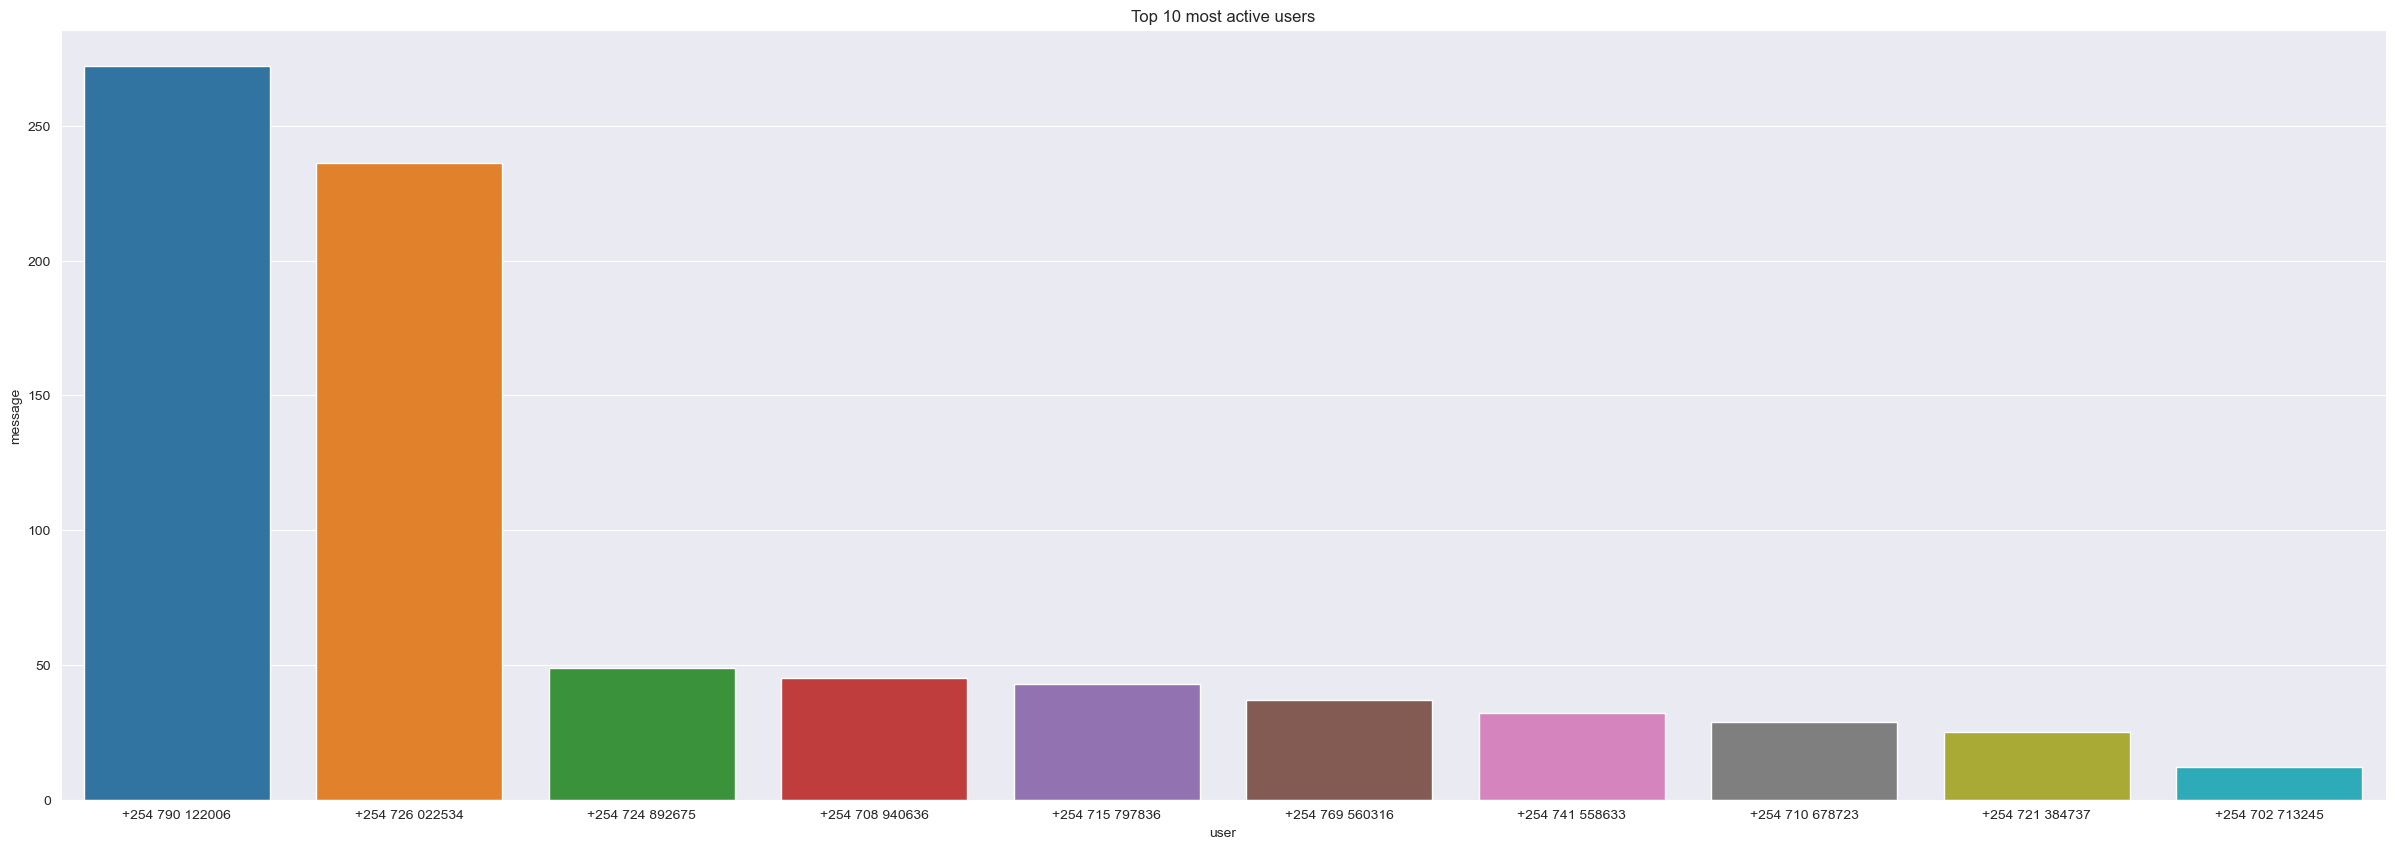

In [75]:
plt.figure(figsize = (30, 10))     

plt.title('Top 10 most active users');
sns.barplot(x=top10_users.user, y=top10_users.message)

In [76]:
## We do the same for the least active users, but this time we set the ascending to `True`

df3 = df.copy()
df3 = df3[df3.user != 'group_notification']

bottom10_users = df3.groupby('user')['message'].count().sort_values(ascending = True)
bottom10_users = bottom10_users.head(25).reset_index()
bottom10_users

,user,message
0,+254 794 800601,1
1,+254 791 966644,1
2,+254 725 170121,1
3,+254 790 801667,1
4,+254 704 705599,1
5,+254 704 743901,1
6,+254 713 404079,1
7,+254 727 797779,1
8,+254 724 017355,1
9,+254 728 918366,1


## Plotting the least active users

<Axes: title={'center': 'Least active users'}, xlabel='user', ylabel='message'>

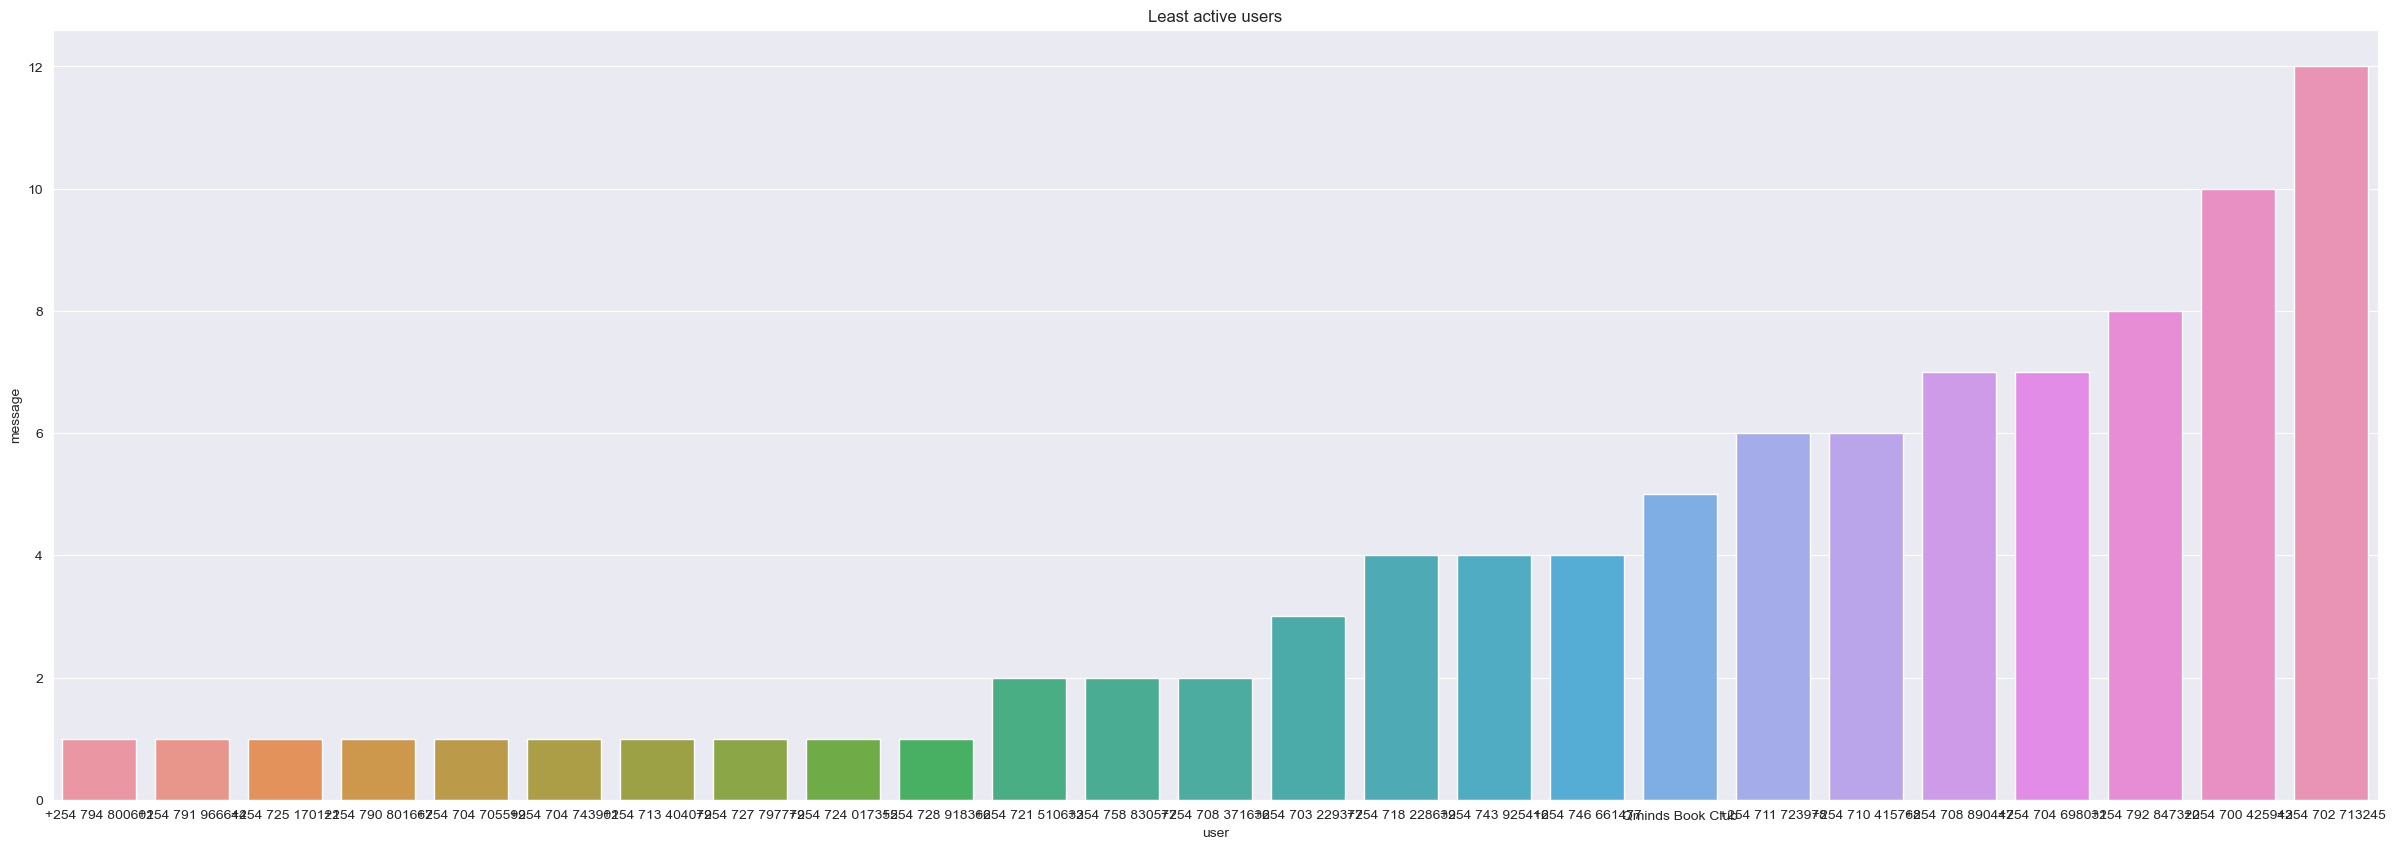

In [77]:
plt.figure(figsize = (30, 10))     

plt.title('Least active users');
sns.barplot(x=bottom10_users.user, y=bottom10_users.message)

## Finding users who sent the most number of media

When exporting the data from Whatsapp, we selected 'without media' and therefore no media was exported. Where a media was sent in the chat, Whatsapp will label that as `<Media omitted>`. That's how we can find users that sent media to the group.

In [78]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media


,user,media_sent
0,+254 726 022534,33
1,+254 790 122006,17
2,+254 715 797836,11
3,+254 724 892675,6
4,+254 769 560316,6
5,+254 708 940636,2
6,+254 700 425943,1
7,+254 702 713245,1
8,+254 703 229377,1
9,+254 718 228639,1


## Plotting a bar graph of users with the most sent media

<Axes: title={'center': 'Users with most sent media'}, xlabel='user', ylabel='media_sent'>

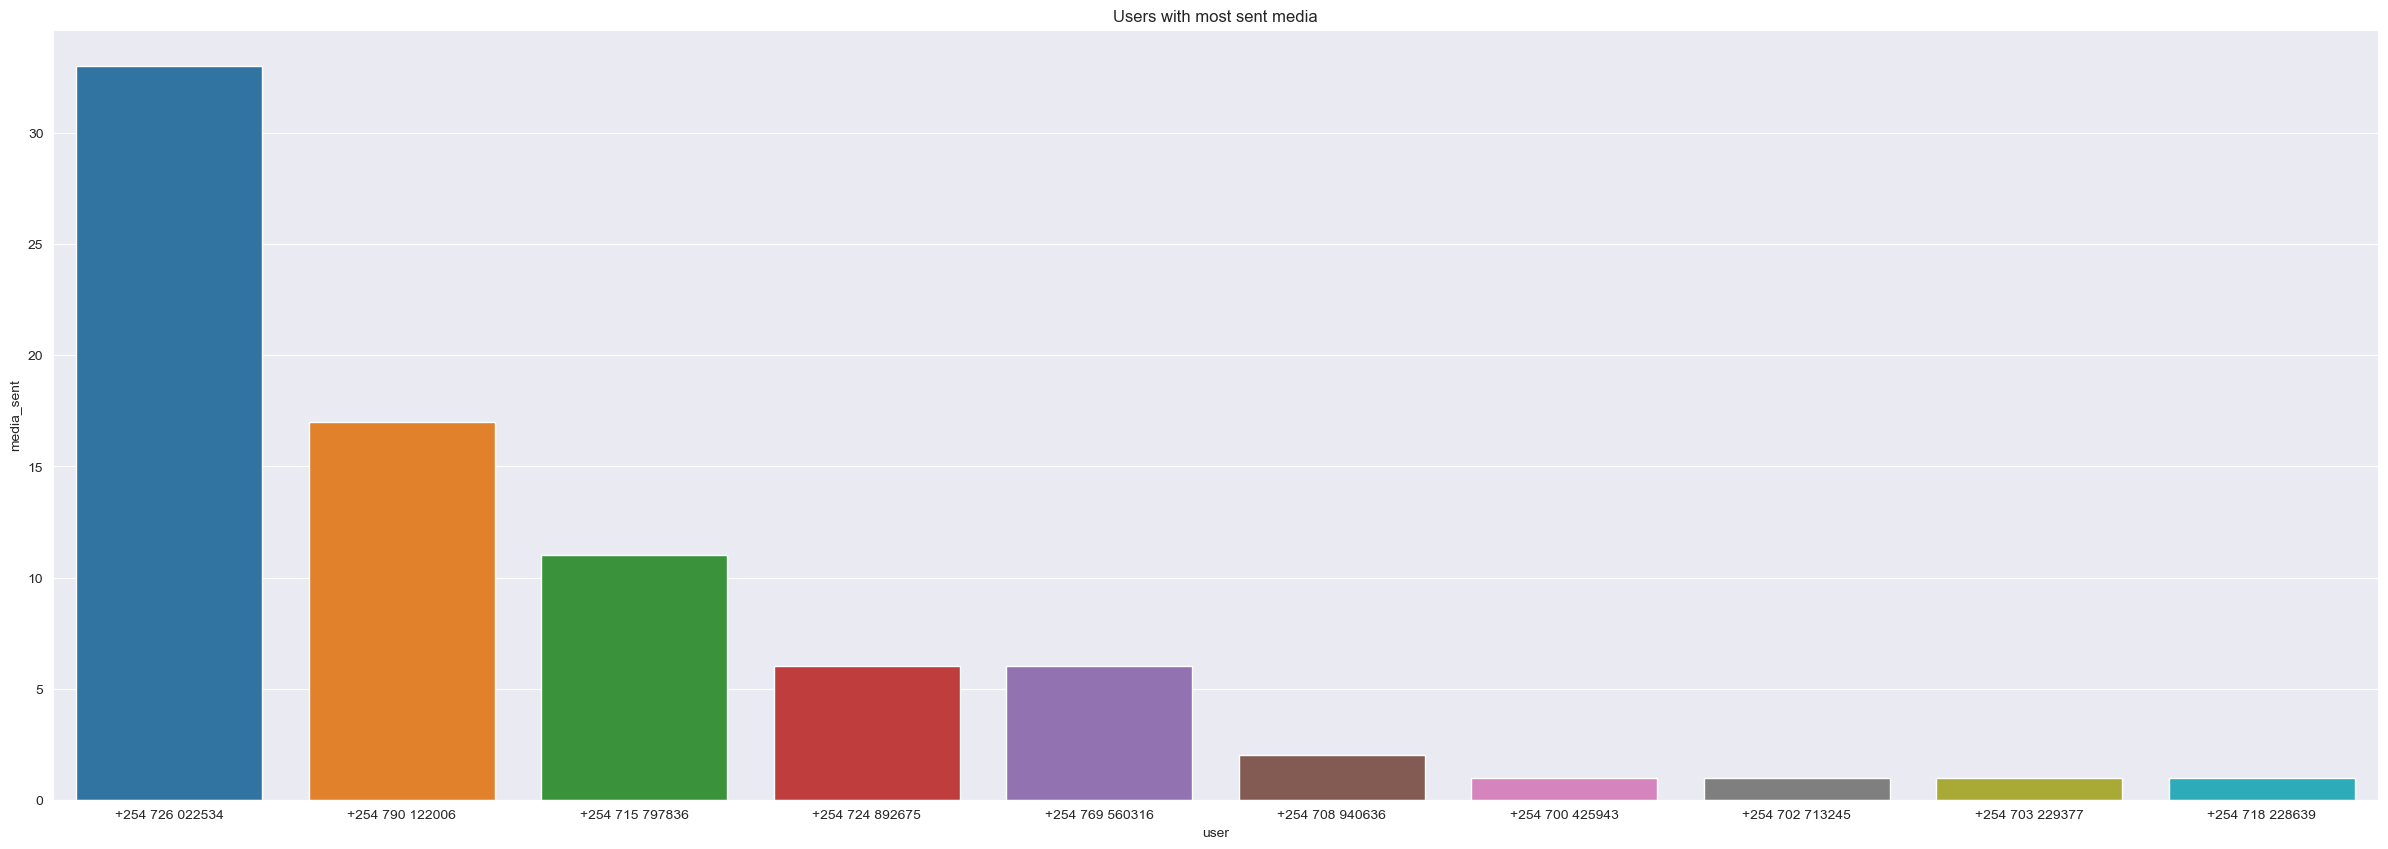

In [79]:
plt.figure(figsize = (30, 10))     

plt.title('Users with most sent media');
sns.barplot(x=top10media.user, y=top10media.media_sent)

## Finding the most active hours of the group chat

In [80]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # new column that will keep count.
 
df3['hour'] = df3['date_time'].apply(lambda x: x.hour)
 
grouped_by_time = df3.groupby('hour').sum('message_count').reset_index().sort_values(by = 'hour')
grouped_by_time

,hour,year,message_count
0,0,2023,1
1,3,8095,4
2,4,4046,2
3,5,8092,4
4,6,10116,5
5,7,38444,19
6,8,103182,51
7,9,86999,43
8,10,161852,80
9,11,125430,62


## Scatter plot to show the most active hours

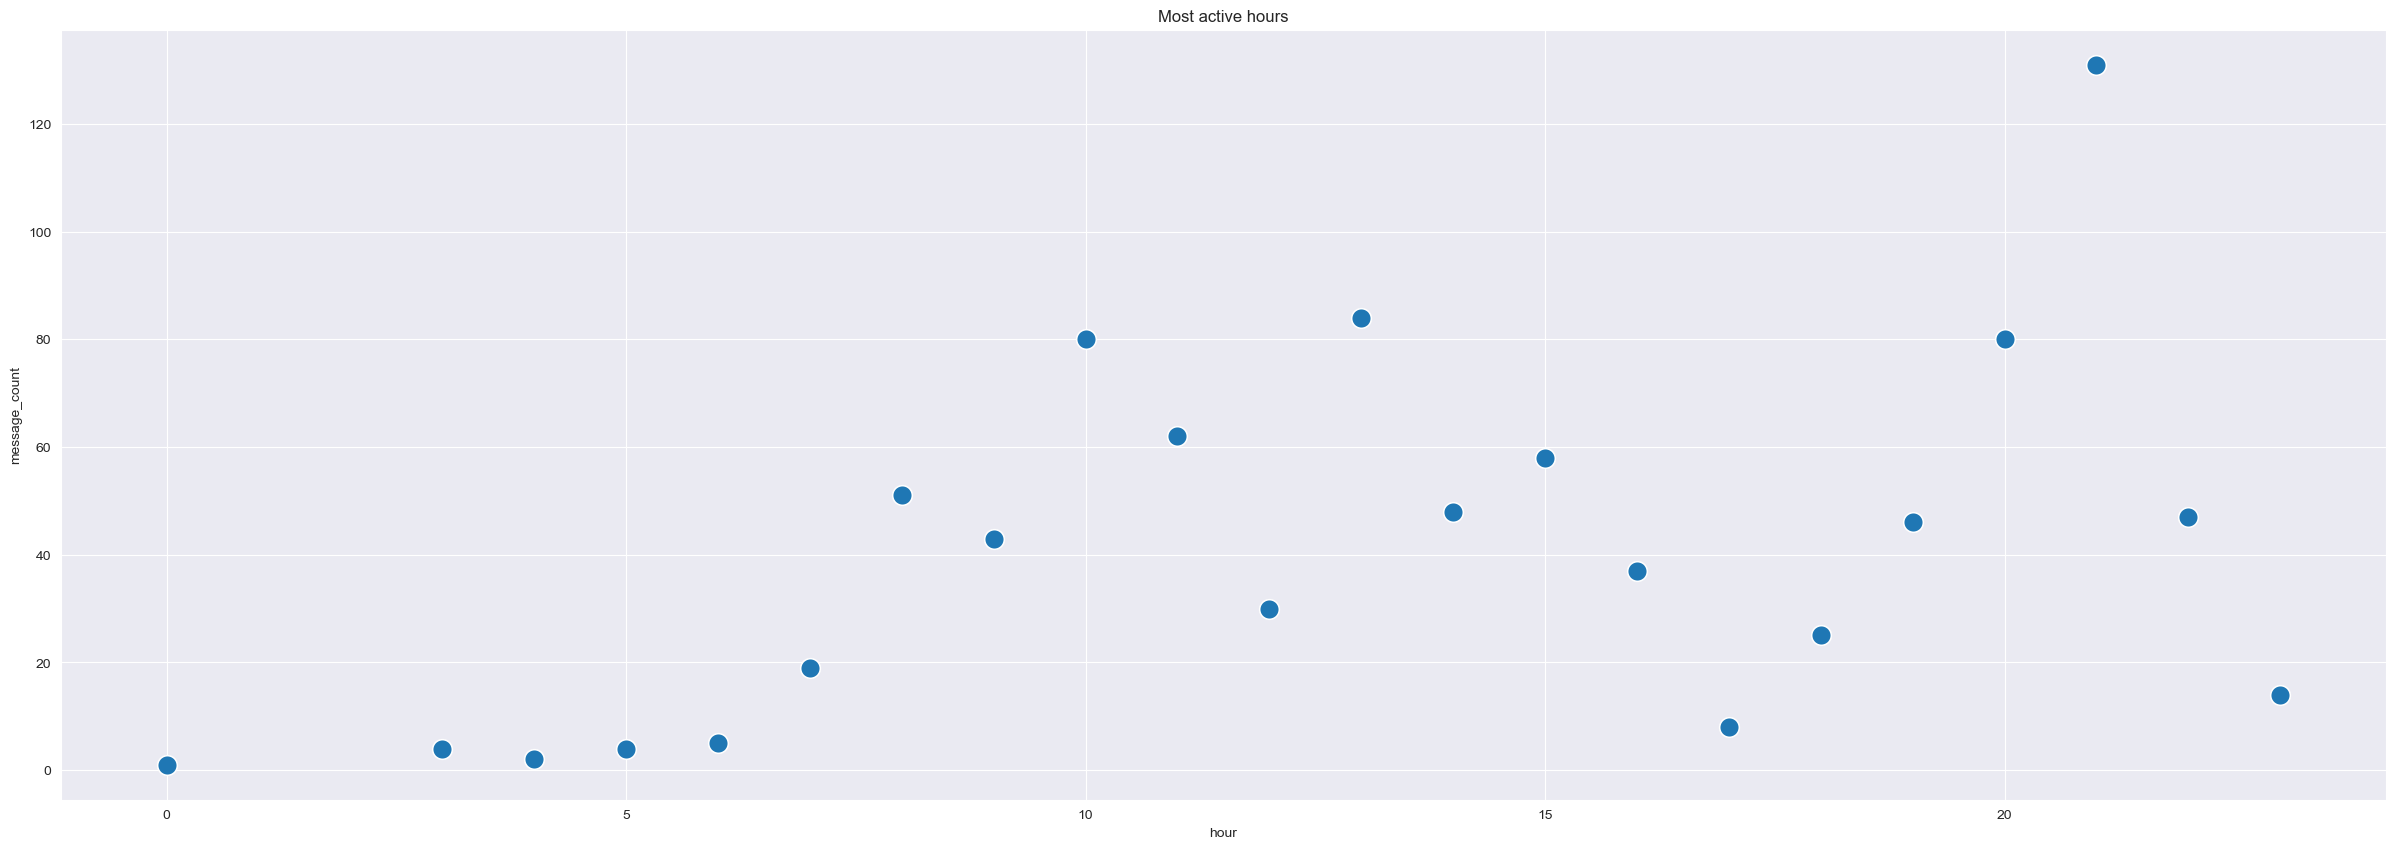

In [81]:
plt.figure(figsize = (30, 10))     

plt.title('Most active hours');
sns.scatterplot(x=grouped_by_time.hour, y=grouped_by_time.message_count, s=200)

plt.show()

At around 10 pm is when the chat get busiest. However, in general we can see that from 10 am to the end of day, users are relatively active

## Finding the most active days

In [82]:
grouped_by_day = df3.groupby('day').sum('message_count').reset_index()[['day','message_count']].sort_values(by = 'day')
grouped_by_day

,day,message_count
0,Fri,52
1,Mon,96
2,Sat,29
3,Sun,77
4,Thu,286
5,Tue,69
6,Wed,270


## Line graph of the most active days

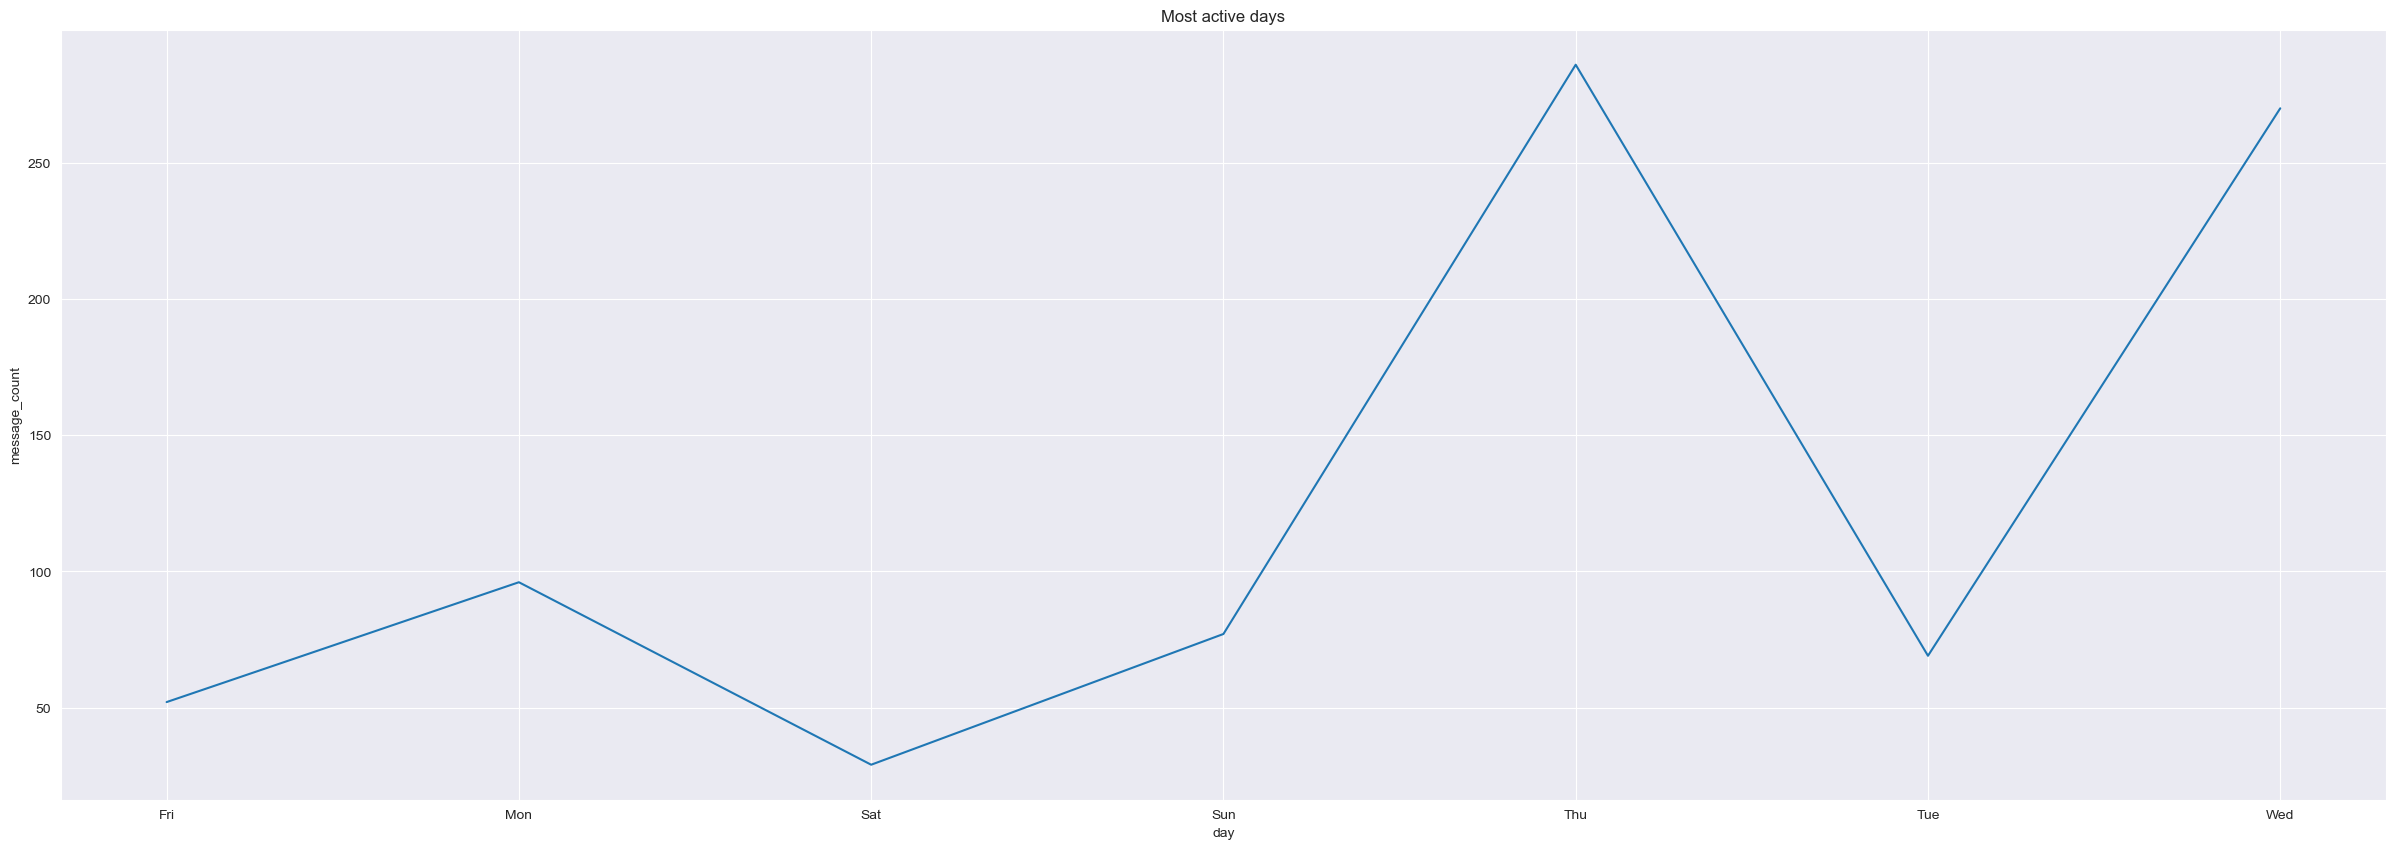

In [83]:
plt.figure(figsize = (30, 10))     

plt.title('Most active days');
sns.lineplot(x=grouped_by_day.day, y=grouped_by_day.message_count)
plt.show()

Thursday and Wednesday appear to be the busiest days of the week.

## Creating a Wordcloud for the whatsapp chat messages

- stopwords --> Words to be avoided while forming the WordCloud,
- removed group_notifications like 'joined', 'deleted';
- removed really common words like "yeah" and "okay".
- stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined','join', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


In [84]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
# stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined','join', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white',  
                min_font_size = 8).generate(comment_words)

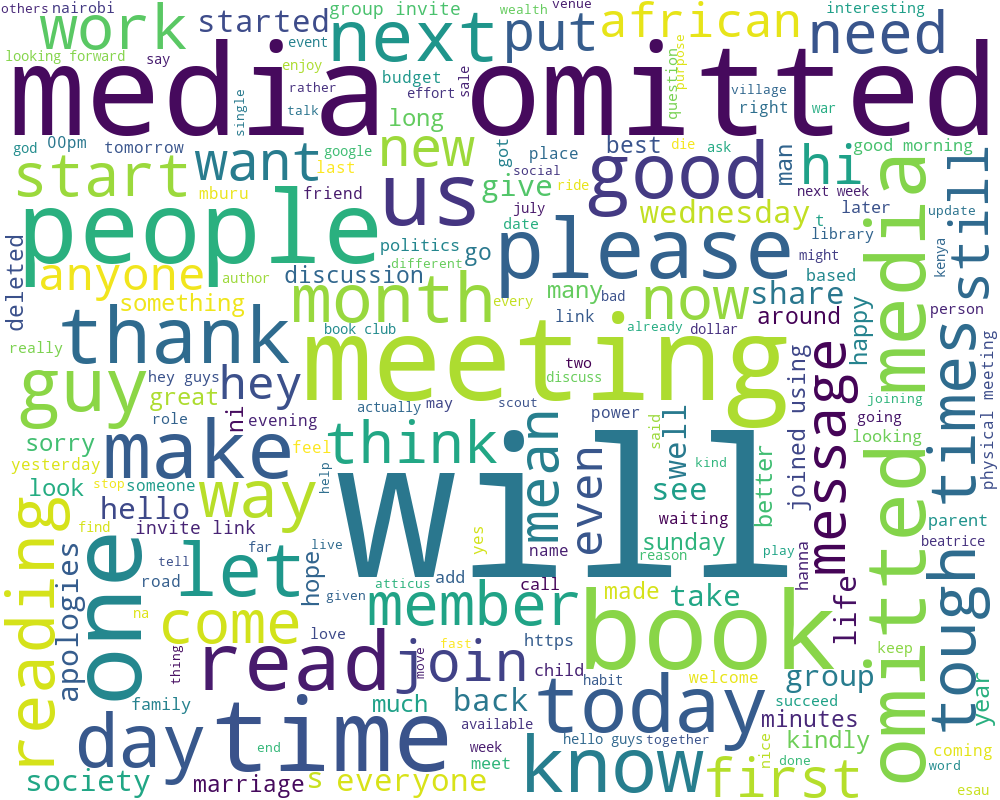

In [85]:
wordcloud.to_image()